**파이프라인(Pipeline)**은 

- 머신러닝의 복잡한 과정을 하나로 묶어줍니다. 

- 실제로 동작하는 자동화된 워크플로우 도구(객체)입니다. 


파이프라인의 핵심 기능
자동화: .fit()과 .predict() 메서드 한 번으로 전처리와 모델 훈련을 모두 처리합니다.

.fit() 실행 시: 파이프라인에 담긴 모든 전처리 단계(fit_transform)를 순차적으로 실행한 후, 마지막으로 모델(fit)을 훈련합니다.

.predict() 실행 시: 새로운 데이터에 대해 이전에 학습한 전처리(transform)를 자동으로 적용한 후, 예측을 수행합니다.

일관성: 훈련 데이터에 적용한 전처리 규칙(예: 평균, 표준편차)을 저장해 두었다가 테스트 데이터에도 그대로 적용하여 데이터 누수를 방지합니다.

GridSearchCV 연동: GridSearchCV와 결합하면 전처리 단계와 모델 하이퍼파라미터를 동시에 최적화할 수 있어 매우 효율적입니다.

==========

수동 vs. 파이프라인 워크플로우 비교


| 수동 방식 (이전 학습) | 파이프라인 방식 (현재 학습) |
|---|---|
| 1. 데이터 수집 | 1. 데이터 수집 |
| 2. `scaler.fit_transform()` (전처리) | 2. **`pipeline.fit()`** (전처리 + 모델 훈련) |
| 3. `model.fit()` (모델 훈련) | (내부적으로 자동 진행) |
| 4. `scaler.transform()` (테스트 데이터 전처리) | 3. **`pipeline.predict()`** (전처리 후 예측) |
| 5. `model.predict()` (예측) | (내부적으로 자동 진행) |


이처럼 파이프라인을 사용하면 코드가 훨씬 간결해지고, 실수할 가능성도 줄어듭니다.



최적의 하이퍼파라미터: {'knn__n_neighbors': 3, 'knn__weights': 'uniform'}
최고 교차 검증 점수: 0.9763

최적 모델의 테스트 정확도: 0.9694


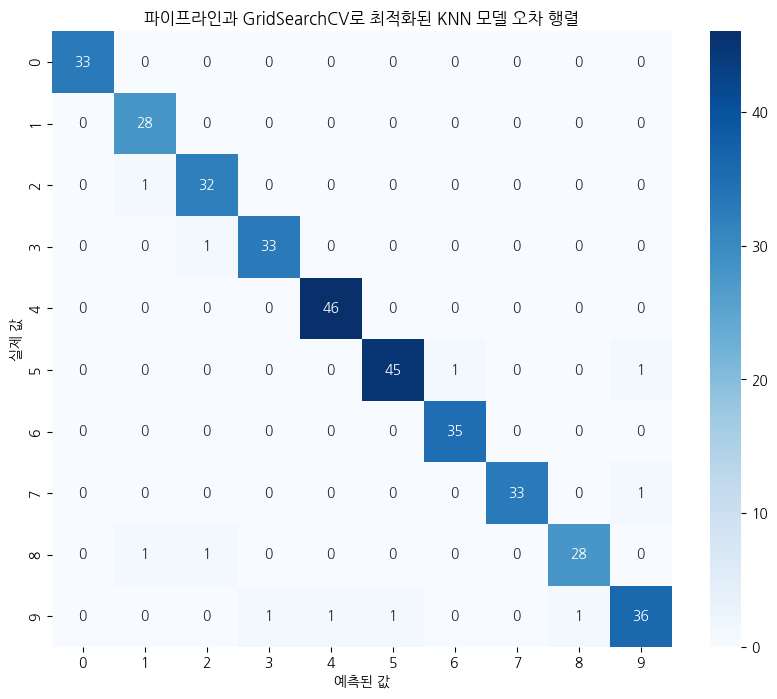

In [ ]:
# 파일명: 22_파이프라인을_활용한_전처리_및_모델_최적화.ipynb

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# -----------------------------------------------------------
# 1. 환경 설정 및 라이브러리 설치 안내
# -----------------------------------------------------------
# 이 코드를 실행하기 위해 필요한 패키지를 설치하는 방법입니다.
# 사용하시는 가상 환경 이름은 'mldl_env_250804'를 자동으로 사용합니다.
# 터미널에서 다음 명령어를 실행하여 필요한 라이브러리를 설치하세요.
# python3 -m pip install scikit-learn matplotlib numpy seaborn

# -----------------------------------------------------------
# 2. 한글 폰트 설정
# -----------------------------------------------------------
# matplotlib에서 한글을 정상적으로 표시하기 위해 폰트를 설정합니다.
# 'NanumGothic' 폰트가 설치되어 있지 않으면 경고가 발생할 수 있습니다.
# 폰트가 없는 경우, 'NanumGothic'을 설치하거나 다른 한글 폰트 이름을 사용하세요.
try:
    font_path = fm.findfont(fm.FontProperties(family='NanumGothic'))
    plt.rcParams['font.family'] = 'NanumGothic'
    plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지
except:
    print("경고: NanumGothic 폰트를 찾을 수 없습니다. 한글을 올바르게 표시하려면 한글 폰트를 설치하세요.")

# -----------------------------------------------------------
# 3. 데이터 준비
# -----------------------------------------------------------
# sklearn에서 제공하는 손글씨 숫자(digits) 데이터셋을 로드합니다.
digits = load_digits()

# 특성(X)과 타겟(y) 데이터를 분리합니다.
X = digits.data
y = digits.target

# -----------------------------------------------------------
# 4. 훈련 세트와 테스트 세트 분리
# -----------------------------------------------------------
# 데이터를 훈련 세트와 테스트 세트로 나눕니다. (80% 훈련, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -----------------------------------------------------------
# 5. 파이프라인(Pipeline) 구축
# -----------------------------------------------------------
# 파이프라인은 여러 전처리 단계와 모델을 순서대로 연결해 줍니다.
# 여기서는 StandardScaler를 사용하여 데이터를 스케일링하고,
# 그 결과를 KNeighborsClassifier에 전달합니다.
# 각 단계는 (이름, 객체) 튜플로 구성됩니다.
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # 첫 번째 단계: 특성을 표준화합니다.
    ('knn', KNeighborsClassifier())   # 두 번째 단계: KNN 모델을 사용합니다.
])

# -----------------------------------------------------------
# 6. GridSearchCV를 사용하여 최적의 하이퍼파라미터 찾기
# -----------------------------------------------------------
# 파이프라인의 각 단계에 대한 하이퍼파라미터를 탐색할 범위를 정의합니다.
# 파이프라인의 단계 이름('knn')과 하이퍼파라미터 이름('n_neighbors', 'weights')을 '__'로 연결합니다.
# n_neighbors는 이웃의 수를, weights는 가중치 부여 방식을 탐색합니다.
param_grid = {
    'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'knn__weights': ['uniform', 'distance']
}

# GridSearchCV 객체를 생성합니다.
# estimator에 파이프라인 객체를 전달하여 전처리부터 모델 훈련까지 한 번에 수행합니다.
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, n_jobs=-1)

# 훈련 데이터를 사용하여 그리드 서치를 실행합니다.
grid_search.fit(X_train, y_train)

# -----------------------------------------------------------
# 7. 최적의 하이퍼파라미터와 모델 성능 확인
# -----------------------------------------------------------
# GridSearchCV가 찾은 최적의 하이퍼파라미터(best_params_)를 출력합니다.
print(f"\n최적의 하이퍼파라미터: {grid_search.best_params_}")
# 결과 설명: 파이프라인 내의 'knn' 단계에서 가장 높은 성능을 보인 'n_neighbors'와 'weights'의 최적 조합을 보여줍니다.

# 최적의 하이퍼파라미터로 훈련된 모델의 최고 점수(best_score_)를 출력합니다.
print(f"최고 교차 검증 점수: {grid_search.best_score_:.4f}")
# 결과 설명: 파이프라인의 전처리 단계와 최적의 하이퍼파라미터를 적용한 모델의 교차 검증 평균 점수입니다.

# 최적의 모델(best_estimator_)을 가져옵니다.
best_model = grid_search.best_estimator_

# -----------------------------------------------------------
# 8. 최적의 모델로 테스트 데이터 평가
# -----------------------------------------------------------
# 최적의 모델을 사용하여 테스트 세트로 예측을 수행합니다.
# 파이프라인이 자동으로 테스트 데이터에도 전처리를 적용한 후 예측합니다.
y_pred = best_model.predict(X_test)

# 최종 정확도(Accuracy)를 계산합니다.
accuracy = accuracy_score(y_test, y_pred)
print(f"\n최적 모델의 테스트 정확도: {accuracy:.4f}")
# 결과 설명: 최적화된 모델이 한 번도 보지 못한 테스트 데이터를 얼마나 잘 예측했는지에 대한 최종 정확도입니다.

# -----------------------------------------------------------
# 9. 오차 행렬 시각화
# -----------------------------------------------------------
# 오차 행렬을 히트맵(heatmap)으로 시각화하여 결과를 쉽게 파악할 수 있습니다.
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=digits.target_names, yticklabels=digits.target_names)
plt.xlabel("예측된 값")
plt.ylabel("실제 값")
plt.title("파이프라인과 GridSearchCV로 최적화된 KNN 모델 오차 행렬")
plt.show()
# 결과 설명: 히트맵은 예측된 값과 실제 값을 비교한 표입니다.
# 대각선에 위치한 값이 높을수록(색이 진할수록) 모델이 정확하게 예측했음을 의미합니다.
# 대각선이 아닌 다른 칸에 값이 있다면, 해당 클래스를 잘못 분류했다는 뜻입니다.



최적의 하이퍼파라미터: {'knn__n_neighbors': 3, 'knn__weights': 'uniform'}
최고 교차 검증 점수: 0.9763

최적 모델의 테스트 정확도: 0.9694


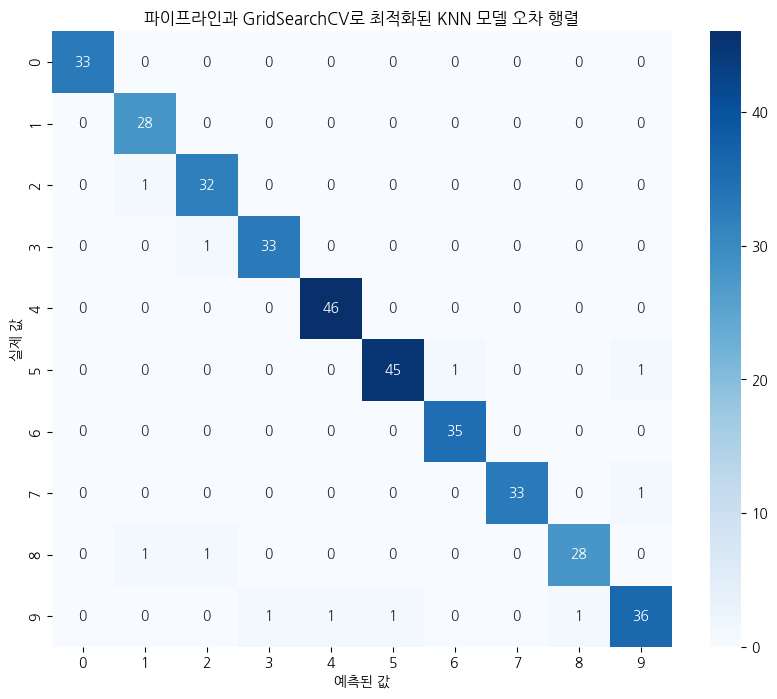

In [ ]:
# 주석 제거 1 : 22_파이프라인을_활용한_전처리_및_모델_최적화.ipynb

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# -----------------------------------------------------------
# 한글 폰트 설정
# -----------------------------------------------------------
try:
    font_path = fm.findfont(fm.FontProperties(family='NanumGothic'))
    plt.rcParams['font.family'] = 'NanumGothic'
    plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지
except:
    print("경고: NanumGothic 폰트를 찾을 수 없습니다. 한글을 올바르게 표시하려면 한글 폰트를 설치하세요.")


# 3. 데이터 준비. sklearn에서 제공하는 손글씨 숫자(digits) 데이터셋을 로드합니다.
digits = load_digits()

# 특성(X)과 타겟(y) 데이터를 분리합니다.
X = digits.data
y = digits.target


# 4. 훈련 세트와 테스트 세트 분리. 데이터를 훈련 세트와 테스트 세트로 나눕니다. (80% 훈련, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 5. 파이프라인(Pipeline) 구축. 각 단계는 (이름, 객체) 튜플로 구성됩니다.
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # 첫 번째 단계: 특성을 표준화합니다.
    ('knn', KNeighborsClassifier())   # 두 번째 단계: KNN 모델을 사용합니다.
])


# 6. GridSearchCV를 사용하여 최적의 하이퍼파라미터 찾기. 
# 파이프라인의 단계 이름('knn')과 하이퍼파라미터 이름('n_neighbors', 'weights')을 '__'로 연결합니다.
# n_neighbors는 이웃의 수를, weights는 가중치 부여 방식을 탐색합니다.
param_grid = {
    'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'knn__weights': ['uniform', 'distance']
}

# GridSearchCV 객체를 생성합니다.
# estimator에 파이프라인 객체를 전달하여 전처리부터 모델 훈련까지 한 번에 수행합니다.
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, n_jobs=-1)

# 훈련 데이터를 사용하여 그리드 서치를 실행합니다.
grid_search.fit(X_train, y_train)

# 7. 최적의 하이퍼파라미터와 모델 성능 확인
print(f"\n최적의 하이퍼파라미터: {grid_search.best_params_}")
# 결과 설명: 파이프라인 내의 'knn' 단계에서 가장 높은 성능을 보인 'n_neighbors'와 'weights'의 최적 조합을 보여줍니다.

# 최적의 하이퍼파라미터로 훈련된 모델의 최고 점수(best_score_)를 출력합니다.
print(f"최고 교차 검증 점수: {grid_search.best_score_:.4f}")
# 결과 설명: 파이프라인의 전처리 단계와 최적의 하이퍼파라미터를 적용한 모델의 교차 검증 평균 점수입니다.

# 최적의 모델(best_estimator_)을 가져옵니다.
best_model = grid_search.best_estimator_


# 8. 최적의 모델로 테스트 데이터 평가
# 최적의 모델을 사용하여 테스트 세트로 예측을 수행합니다.
# 파이프라인이 자동으로 테스트 데이터에도 전처리를 적용한 후 예측합니다.
y_pred = best_model.predict(X_test)

# 최종 정확도(Accuracy)를 계산합니다.
accuracy = accuracy_score(y_test, y_pred)
print(f"\n최적 모델의 테스트 정확도: {accuracy:.4f}")
# 결과 설명: 최적화된 모델이 한 번도 보지 못한 테스트 데이터를 얼마나 잘 예측했는지에 대한 최종 정확도입니다.


# 9. 오차 행렬 시각화. 오차 행렬을 히트맵(heatmap)으로 시각화하여 결과를 쉽게 파악할 수 있습니다.
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=digits.target_names, yticklabels=digits.target_names)
plt.xlabel("예측된 값")
plt.ylabel("실제 값")
plt.title("파이프라인과 GridSearchCV로 최적화된 KNN 모델 오차 행렬")
plt.show()
# 결과 설명: 히트맵은 예측된 값과 실제 값을 비교한 표입니다.
# 대각선에 위치한 값이 높을수록(색이 진할수록) 모델이 정확하게 예측했음을 의미합니다.
# 대각선이 아닌 다른 칸에 값이 있다면, 해당 클래스를 잘못 분류했다는 뜻입니다.

In [ ]:
# 주석 제거 2 :  22_파이프라인을_활용한_전처리_및_모델_최적화.ipynb

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# 한글 폰트 설정
try:
    font_path = fm.findfont(fm.FontProperties(family='NanumGothic'))
    plt.rcParams['font.family'] = 'NanumGothic'
    plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지
except:
    print("경고: NanumGothic 폰트를 찾을 수 없습니다. 한글을 올바르게 표시하려면 한글 폰트를 설치하세요.")

# 3. 데이터 준비
digits = load_digits()

# 특성(X)과 타겟(y) 데이터를 분리합니다.
X = digits.data
y = digits.target

# 4. 훈련 세트와 테스트 세트 분리. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. 파이프라인(Pipeline) 구축. 
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # 첫 번째 단계: 특성을 표준화합니다.
    ('knn', KNeighborsClassifier())   # 두 번째 단계: KNN 모델을 사용합니다.
])

# 6. GridSearchCV를 사용하여 최적의 하이퍼파라미터 찾기. 
param_grid = {
    'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'knn__weights': ['uniform', 'distance']
}

# GridSearchCV 객체를 생성합니다.
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, n_jobs=-1)

# 훈련 데이터를 사용하여 그리드 서치를 실행합니다.
grid_search.fit(X_train, y_train)

# 7. 최적의 하이퍼파라미터와 모델 성능 확인
print(f"\n최적의 하이퍼파라미터: {grid_search.best_params_}")

# 최적의 하이퍼파라미터로 훈련된 모델의 최고 점수(best_score_)를 출력합니다.
print(f"최고 교차 검증 점수: {grid_search.best_score_:.4f}")

# 최적의 모델(best_estimator_)을 가져옵니다.
best_model = grid_search.best_estimator_


# 8. 최적의 모델로 테스트 데이터 평가
y_pred = best_model.predict(X_test)

# 최종 정확도(Accuracy)를 계산합니다.
accuracy = accuracy_score(y_test, y_pred)
print(f"\n최적 모델의 테스트 정확도: {accuracy:.4f}")

# 9. 오차 행렬 시각화. 오차 행렬을 히트맵(heatmap)으로 시각화하여 결과를 쉽게 파악할 수 있습니다.
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=digits.target_names, yticklabels=digits.target_names)
plt.xlabel("예측된 값")
plt.ylabel("실제 값")
plt.title("파이프라인과 GridSearchCV로 최적화된 KNN 모델 오차 행렬")
plt.show()
# 결과 설명: 히트맵은 예측된 값과 실제 값을 비교한 표입니다.
# 대각선에 위치한 값이 높을수록(색이 진할수록) 모델이 정확하게 예측했음을 의미합니다.
# 대각선이 아닌 다른 칸에 값이 있다면, 해당 클래스를 잘못 분류했다는 뜻입니다.

In [ ]:
# 주석 제거 3 : 22_파이프라인을_활용한_전처리_및_모델_최적화.ipynb

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# 한글 폰트 설정
try:
    font_path = fm.findfont(fm.FontProperties(family='NanumGothic'))
    plt.rcParams['font.family'] = 'NanumGothic'
    plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지
except:
    print("경고: NanumGothic 폰트를 찾을 수 없습니다. 한글을 올바르게 표시하려면 한글 폰트를 설치하세요.")


digits = load_digits()

X = digits.data
y = digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('knn', KNeighborsClassifier())  
])

param_grid = {
    'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'knn__weights': ['uniform', 'distance']
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

print(f"\n최적의 하이퍼파라미터: {grid_search.best_params_}")

print(f"최고 교차 검증 점수: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\n최적 모델의 테스트 정확도: {accuracy:.4f}")

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=digits.target_names, yticklabels=digits.target_names)
plt.xlabel("예측된 값")
plt.ylabel("실제 값")
plt.title("파이프라인과 GridSearchCV로 최적화된 KNN 모델 오차 행렬")
plt.show()